In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
import h5py
import toml
from pathlib import Path
import geopandas as gpd


valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'summary_configuration.toml'))

root_dir = '../../../..'

conn = create_engine(f'sqlite:///{root_dir}/inputs/db/'+input_config['db_name'])



pd.options.display.float_format = '{:0,.0f}'.format

# Generation
Trips are generated for non-work external, airport, and truck demand

In [2]:
df = pd.read_csv(Path(root_dir, "outputs/supplemental/7_balance_trip_ends.csv"))
col_list = ['hbw1','hbw2','hbw3','hbw4','col','hsp','hbo','sch','oto','wto','cvh','mtk','htk','dtk']
df_pro = pd.DataFrame(df.sum()[[i+"pro" for i in col_list]], columns=['Productions'])
df_pro.index = col_list
df_att = pd.DataFrame(df.sum()[[i+"att" for i in col_list]],columns=["Attractions"])
df_att.index = col_list
df_pro.merge(df_att, left_index=True, right_index=True)



,Productions,Attractions
hbw1,"291,331","291,331"
hbw2,"666,175","666,175"
hbw3,"602,747","602,747"
hbw4,"1,246,998","1,246,998"
col,"122,899","122,899"
hsp,"1,751,683","1,751,683"
hbo,"5,823,911","5,823,911"
sch,"1,306,546","1,306,546"
oto,"2,894,415","2,894,415"
wto,"1,779,004","1,779,004"


# Airport Travel
Trips generated by travel to Sea-Tac International Airport

In [3]:
df = pd.read_csv(Path(root_dir, "outputs/supplemental/7_balance_trip_ends.csv"))

df = pd.DataFrame(df[['airport']].sum(), columns=['Person Trips'])
df.index = ['Trips Generated (Output)']

# Enplanements
airport_control_total = pd.read_sql(
        "SELECT * FROM seatac WHERE year==" + str(input_config["model_year"]), con=conn
    )["enplanements"].values[0].astype('float')
df_obs = pd.DataFrame([airport_control_total], columns=['Person Trips'], index=["Enplanements (Input)"])
pd.concat([df_obs, df])

,Person Trips
Enplanements (Input),"141,070"
Trips Generated (Output),"141,070"


In [4]:

parcel_geog = pd.read_sql(
        "SELECT ParcelID, district_name, TAZ FROM parcel_2023_geography",
        con=conn,
    )

# Set parcel taz/district equal to the number of parcels within the area
parcel_geog = parcel_geog[~parcel_geog['district_name'].isnull()]
parcel_geog_grouped = parcel_geog.groupby('TAZ')['district_name'].agg(lambda x: x.value_counts().idxmax()).reset_index()

In [5]:
df = pd.read_csv(Path(root_dir, "outputs/supplemental/7_balance_trip_ends.csv"))

df_airport = df.merge(parcel_geog_grouped, left_index=True, right_on='TAZ', how='left')[['airport','district_name']]
df = df_airport.groupby('district_name').sum()[['airport']]
df.loc['Total', :] = df.sum()
df.columns = ['Person Trips']
df

,Person Trips
district_name,
East Side,"24,849"
Everett-Lynwood-Edmonds,"10,120"
Kitsap,"8,259"
North Seattle-Shoreline,"11,460"
Renton-FedWay-Kent,"21,864"
S.Kitsap,"2,067"
Seattle CBD,"12,579"
South Pierce,"16,721"
Suburban Snohomish,"15,249"


In [6]:

df = pd.read_csv(Path(root_dir, "outputs/supplemental/airport_veh_trips.csv"))
df.rename(columns={"Unnamed: 0": "Mode"}, inplace=True)
df = df[df['Mode'] != "util_sum"]

# df['Share'] = (df['Share'] * 100).round(1).astype(str) + '%'
# add total row
df.loc['Total','total'] = df['total'].sum()
df["Share"] = df['total']/df[~df.index.isin(['Total'])]['total'].sum()
df.fillna(" ", inplace=True)
df.style.format({'total': '{:0,.0f}', 'Share': '{:.1%}'})


,Mode,total,Share
1,sov,"56,474",58.4%
2,hov2,"19,626",20.3%
3,hov3,"9,878",10.2%
4,walk,297,0.3%
5,bike,214,0.2%
6,trnst,"1,799",1.9%
7,litrat,"8,293",8.6%
8,commuter_rail,133,0.1%
9,ferry,6,0.0%
10,passenger_ferry,29,0.0%


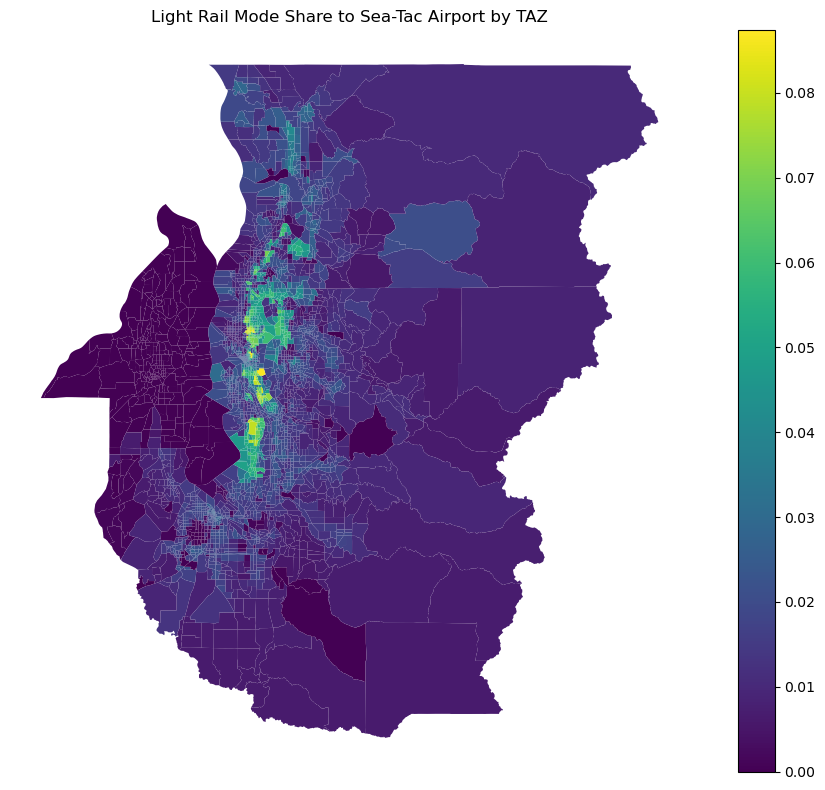

In [15]:
import matplotlib
from matplotlib import pyplot as plt

try:
    gdf_taz = gpd.read_file(Path(root_dir,"inputs/base_year/taz2010.geojson"))
    gdf_taz['taz'] = gdf_taz['taz'].astype('float').astype('int')
    df = pd.read_csv(Path(root_dir, "outputs/supplemental/avg_mode_shares_origins.csv"))
    df.rename(columns={'Unnamed: 0': 'taz'}, inplace=True)
    # TAZ seems to be 0-based index
    df = df[df['taz'] <= 3699]
    df['taz'] = df['taz'].apply(lambda x: x+1).astype('int64')
    df[['taz','litrat']]
    df = gdf_taz.merge(df[['taz','litrat']], on='taz')
    ax = df.plot(column='litrat', legend=True, figsize=(10, 8), cmap='viridis')
    ax.set_title("Light Rail Mode Share to Sea-Tac Airport by TAZ Origin")
    ax.set_axis_off()
    # Enable interactive zoom if running in a Jupyter environment that supports it
    try:
        if matplotlib.get_backend() == 'module://matplotlib_inline.backend_inline':
            plt.tight_layout()
            plt.show()
        else:
            # For interactive backends, enable pan/zoom
            import matplotlib.pyplot as plt
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print("Interactive zoom not supported in this environment:", e)
except:
    print("Error loading TAZ data")

# All Externals
Work and Non-Work Trips are calculated first.
Airport trips are then added on to work and non-work trips

In [7]:
results_dict = {}
tod_list = ['5to6','6to7','7to8','8to9','9to10','10to14','14to15','15to16','16to17','17to18','18to20','20to5']
for tod in tod_list:
    # print(tod)
    myh5 = h5py.File(Path(root_dir,f"outputs/supplemental/external_work_{tod}.h5"))
    tod_dict = {}
    for mode in ['sov','hov2','hov3']:
        tod_dict[mode] = myh5[mode][:].sum()
    results_dict[tod] = tod_dict
    myh5.close()

In [8]:
df = pd.DataFrame(pd.DataFrame(results_dict).T.sum(), columns=['Work Trips'])

myh5 = h5py.File(Path(root_dir,f"outputs/supplemental/external_non_work.h5"))
for mode in ['sov','hov2','hov3']:
    df.loc[mode, "Non-Work Trips"] = myh5[mode][:].sum()
df['Total'] = df.sum(axis=1)
df.loc["total", :] = df.sum()
df

,Work Trips,Non-Work Trips,Total
sov,"237,921","131,815","369,736"
hov2,"18,310","21,420","39,729"
hov3,"6,394","11,534","17,928"
total,"262,624","164,769","427,393"


In [9]:

mode_list = ['bike', 'commuter_rail', 'ferry', 'hov2_inc2', 'hov3_inc2', 'litrat', 'passenger_ferry', 'sov_inc2', 'trnst', 'walk']
df_results = pd.DataFrame()
# Get all airport trips by mode
results_dict = {}
for tod in tod_list:
    # print(tod)
    myh5 = h5py.File(Path(root_dir,f"outputs/supplemental/{tod}.h5"))
    tod_dict = {}
    for mode in mode_list:
        tod_dict[mode] = myh5[mode][:].sum()
    results_dict[tod] = tod_dict
    myh5.close()

In [10]:


df = pd.DataFrame(results_dict).T
df = pd.DataFrame(df[["sov_inc2","hov2_inc2","hov3_inc2","walk","bike","trnst","ferry","passenger_ferry","commuter_rail","litrat"]].sum(),
             columns=['Trips'])
df.loc["Total", :] = df.sum(axis=0)
df["Share"] = df['Trips']/df[~df.index.isin(['Total'])]['Trips'].sum()
df.fillna(" ", inplace=True)
df.style.format({'Trips': '{:0,.0f}', 'Share': '{:.1%}'})



,Trips,Share
sov_inc2,"426,446",81.3%
hov2_inc2,"59,397",11.3%
hov3_inc2,"27,787",5.3%
walk,297,0.1%
bike,213,0.0%
trnst,"1,786",0.3%
ferry,6,0.0%
passenger_ferry,29,0.0%
commuter_rail,132,0.0%
litrat,"8,263",1.6%


In [11]:
df = pd.read_csv(Path(root_dir, "outputs/supplemental/airport_veh_trips_by_tod.csv"))
df = df.groupby("tod").sum()[["total"]]
# df["Share"] = df['total']/df['total'].sum()
# df['Share'] = (df['Share'] * 100).round(1).astype(str) + '%'
df = df.loc[tod_list]

df.loc['Total','total'] = df['total'].sum()
df["Share"] = df['total']/df[~df.index.isin(['Total'])]['total'].sum()
df.fillna(" ", inplace=True)
df.style.format({'total': '{:0,.0f}', 'Share': '{:.1%}'})

,total,Share
tod,,
5to6,"20,651",3.9%
6to7,"27,964",5.3%
7to8,"31,507",6.0%
8to9,"29,873",5.7%
9to10,"28,574",5.4%
10to14,"115,607",22.0%
14to15,"32,531",6.2%
15to16,"33,281",6.3%
16to17,"32,944",6.3%
